# PART I

# Functions and libraries

In [50]:
from scipy.interpolate import interpn
import xarray as xr
import numpy as np
import json
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
import haversine
import geojsoncontour
import geojson

def iso_to_unix(iso_time):
    iso_time = iso_time.split('.')[0]
    dt = datetime.strptime(iso_time, "%Y-%m-%dT%H:%M:%S")
    unix_time = dt.timestamp()
    
    return unix_time

# Load ash.nc data

In [2]:
ash = xr.open_dataset("ash.nc")

SO2=ash["SO2_fl"].values.tolist()
tephra=ash["tephra_fl"].values.tolist()
latGrid=np.array(ash["lat"])
lonGrid=np.array(ash["lon"])
heiGrid=np.array(30.48*ash["fl"])
timeGrid=[iso_to_unix(str(i)) for i in np.array(ash["time"])]

# Load Avions.json data

In [3]:
with open("Avio1.json", "r") as json_file:
    data1 = json.load(json_file)
with open("Avio2.json", "r") as json_file:
    data2 = json.load(json_file)
with open("Avio3.json", "r") as json_file:
    data3 = json.load(json_file)

latPlane1 = []
lonPlane1 = []
heiPlane1 = []
timePlane1 = []

latPlane2 = []
lonPlane2 = []
heiPlane2 = []
timePlane2 = []

latPlane3 = []
lonPlane3 = []
heiPlane3 = []
timePlane3 = []

for i in data1["data"]["flight"]["track"]:
    heiPlane1.append(i["altitude"]["meters"])
    timePlane1.append(i["timestamp"])
    latPlane1.append(i["latitude"])
    lonPlane1.append(i["longitude"])
for i in data2["data"]["flight"]["track"]:
    heiPlane2.append(i["altitude"]["meters"])
    timePlane2.append(i["timestamp"])
    latPlane2.append(i["latitude"])
    lonPlane2.append(i["longitude"])
for i in data3["data"]["flight"]["track"]:
    heiPlane3.append(i["altitude"]["meters"])
    timePlane3.append(i["timestamp"])
    latPlane3.append(i["latitude"])
    lonPlane3.append(i["longitude"])

# Interpolate and map the plane trajectory

In [4]:
volumePlane1 = [0]
volumePlane2 = [0]
volumePlane3 = [0]

radius = 1.682/2
surface = np.pi*radius*radius

for i in range(len(timePlane1)-1):
    x0 = [latPlane1[i],lonPlane1[i]]
    x1 = [latPlane1[i+1],lonPlane1[i+1]]
    dist=haversine.haversine(x0,x1)*10**(3)
    volumePlane1.append(dist*surface*2)
    
for i in range(len(timePlane2)-1):
    x0 = [latPlane2[i],lonPlane2[i]]
    x1 = [latPlane2[i+1],lonPlane2[i+1]]
    dist = haversine.haversine(x0,x1)*10**(3)
    volumePlane2.append(dist*surface*2)
    
for i in range(len(timePlane3)-1):
    x0 = [latPlane3[i],lonPlane3[i]]
    x1 = [latPlane3[i+1],lonPlane3[i+1]]
    dist=haversine.haversine(x0,x1)*10**(3)
    volumePlane3.append(dist*surface*2)

In [5]:
points1 = list(zip(timePlane1,heiPlane1,latPlane1,lonPlane1))
points2 = list(zip(timePlane2,heiPlane2,latPlane2,lonPlane2))
points3 = list(zip(timePlane3,heiPlane3,latPlane3,lonPlane3))

listPoints1 = []
listPoints2 = []
listPoints3 = []

for i in points1:
    listPoints1.append(list(i))
for i in points2:
    listPoints2.append(list(i))
for i in points3:
    listPoints3.append(list(i))

S1c = interpn([timeGrid,heiGrid,latGrid,lonGrid], SO2, listPoints1, method='linear',bounds_error=False, fill_value=0)
S2c = interpn([timeGrid,heiGrid,latGrid,lonGrid], SO2, listPoints2, method='linear',bounds_error=False, fill_value=0)
S3c = interpn([timeGrid,heiGrid,latGrid,lonGrid], SO2, listPoints3, method='linear',bounds_error=False, fill_value=0)

T1c = interpn([timeGrid,heiGrid,latGrid,lonGrid], tephra, listPoints1, method='linear',bounds_error=False, fill_value=0)
T2c = interpn([timeGrid,heiGrid,latGrid,lonGrid], tephra, listPoints2, method='linear',bounds_error=False, fill_value=0)
T3c = interpn([timeGrid,heiGrid,latGrid,lonGrid], tephra, listPoints3, method='linear',bounds_error=False, fill_value=0)

In [6]:
S1 = []
S2 = []
S3 = []

T1 = []
T2 = []
T3 = []

for i in range(len(S1c)):
    S1.append(S1c[i]*volumePlane1[i])
    T1.append(T1c[i]*volumePlane1[i])
for i in range(len(S2c)):
    S2.append(S2c[i]*volumePlane2[i])
    T2.append(T2c[i]*volumePlane2[i])
for i in range(len(S3c)):
    S3.append(S3c[i]*volumePlane3[i])
    T3.append(T3c[i]*volumePlane3[i])

# Plot [SO2]-time

Total SO2 plane1 = 0.0009048175327400592 g
Total Tephra plane1 = 1195104.728012918 g

Total SO2 plane2 = 0.0 g
Total Tephra plane2 = 0.0 g

Total SO2 plane3 = 2.3001459269938964e-07 g
Total Tephra plane3 = 2067765.0161610674 g



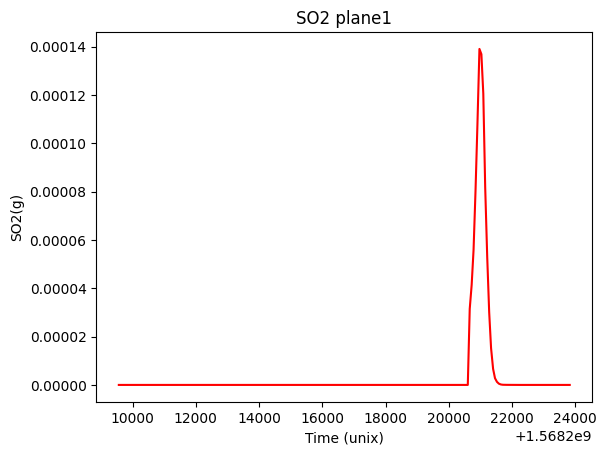

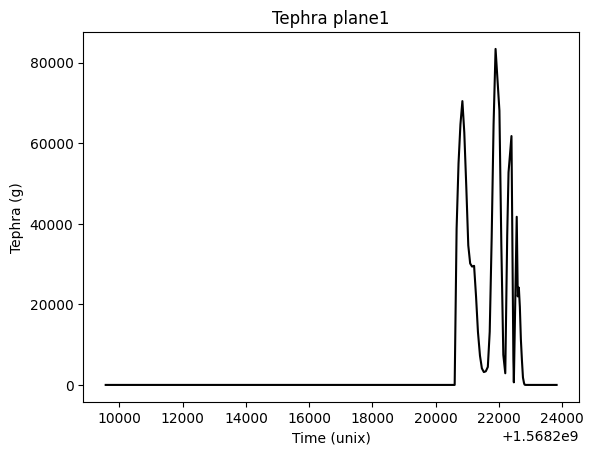

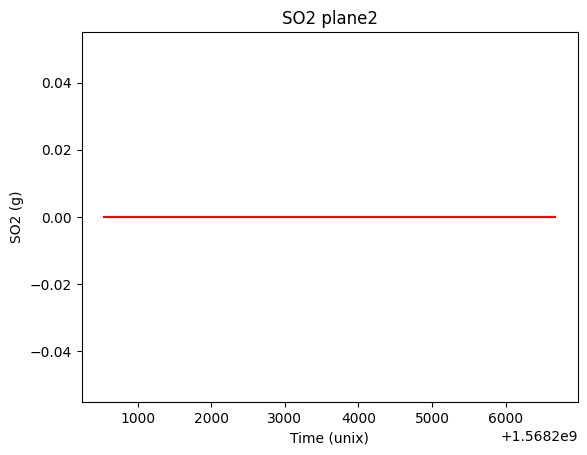

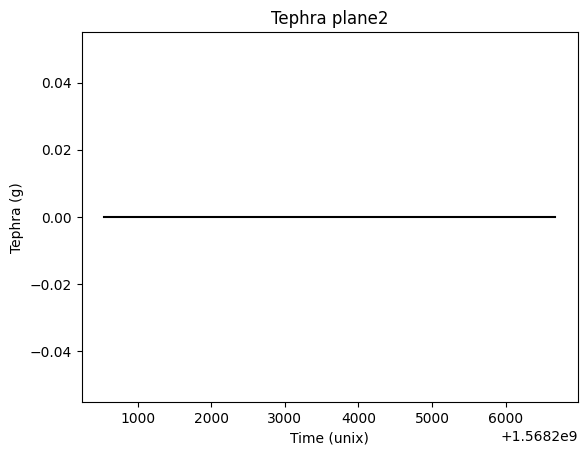

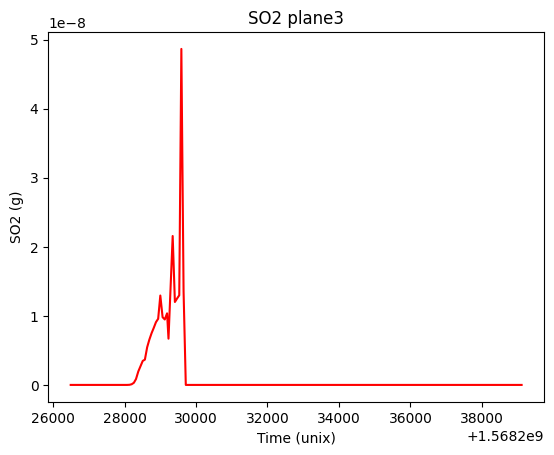

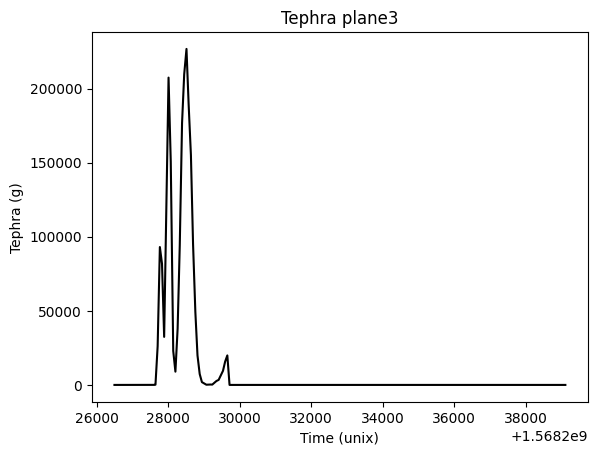

In [7]:
print(f"Total SO2 plane1 = {sum(S1)} g")
print(f"Total Tephra plane1 = {sum(T1)} g\n")
print(f"Total SO2 plane2 = {sum(S2)} g")
print(f"Total Tephra plane2 = {sum(T2)} g\n")
print(f"Total SO2 plane3 = {sum(S3)} g")
print(f"Total Tephra plane3 = {sum(T3)} g\n")

plt.plot(timePlane1,S1, color='r', label='SO2')
plt.title("SO2 plane1")
plt.xlabel("Time (unix)")
plt.ylabel("SO2(g)")
plt.show()
plt.plot(timePlane1,T1, color='k', label='Tephra')
plt.title("Tephra plane1")
plt.xlabel("Time (unix)")
plt.ylabel("Tephra (g)")
plt.show()
plt.plot(timePlane2,S2, color='r',label='SO2')
plt.title("SO2 plane2")
plt.xlabel("Time (unix)")
plt.ylabel("SO2 (g)")
plt.show()
plt.plot(timePlane2,T2, color='k',label='Tephra')
plt.title("Tephra plane2")
plt.xlabel("Time (unix)")
plt.ylabel("Tephra (g)")
plt.show()
plt.plot(timePlane3,S3, color='r', label='SO2')
plt.title("SO2 plane3")
plt.xlabel("Time (unix)")
plt.ylabel("SO2 (g)")
plt.show()
plt.plot(timePlane3,T3, color='k', label='Tephra')
plt.title("Tephra plane3")
plt.xlabel("Time (unix)")
plt.ylabel("Tephra (g)")
plt.show()

# Create nested lists

In [86]:
timePlane1ISO = [datetime.fromtimestamp(t).isoformat() for t in timePlane1]
timePlane2ISO = [datetime.fromtimestamp(t).isoformat() for t in timePlane2]
timePlane3ISO = [datetime.fromtimestamp(t).isoformat() for t in timePlane3]

Plane1 = list(zip(timePlane1ISO,heiPlane1,latPlane1,lonPlane1,S1,np.cumsum(S1),T1,np.cumsum(T1)))
Plane2 = list(zip(timePlane2ISO,heiPlane2,latPlane2,lonPlane2,S2,np.cumsum(S2),T2,np.cumsum(T2)))
Plane3 = list(zip(timePlane3ISO,heiPlane3,latPlane3,lonPlane3,S3,np.cumsum(S3),T3,np.cumsum(T3)))

# CSV conversion

In [88]:
columnsNames = ['Time (ISO)','Height (meters)','Latitude (º)','Longitude (º)','SO2 (g)','SO2 accumulated (g)','Tephra (g)','Tephra accumulated (g)']


df1 = pd.DataFrame(Plane1, columns=columnsNames)
df1.to_csv("Plane1.csv", index=False)

df2 = pd.DataFrame(Plane2, columns=columnsNames)
df2.to_csv("Plane2.csv", index=False)

df3 = pd.DataFrame(Plane3, columns=columnsNames)
df3.to_csv("Plane3.csv", index=False)


Time (ISO)  Height (meters)  Latitude (º)  Longitude (º)  \
0    2019-09-11T15:46:07                0     51.108143      16.882133   
1    2019-09-11T15:46:51                0     51.107929      16.881960   
2    2019-09-11T15:47:16                0     51.107677      16.881752   
3    2019-09-11T15:47:39                0     51.107468      16.881580   
4    2019-09-11T15:50:01                0     51.107609      16.881275   
..                   ...              ...           ...            ...   
378  2019-09-11T19:43:16                0     63.992889     -22.627611   
379  2019-09-11T19:43:23                0     63.992867     -22.628086   
380  2019-09-11T19:43:31                0     63.992855     -22.628773   
381  2019-09-11T19:43:38                0     63.992847     -22.629171   
382  2019-09-11T19:43:44                0     63.992844     -22.629379   

     SO2 (g)  SO2 accumulated (g)  Tephra (g)  Tephra accumulated (g)  
0        0.0             0.000000         0.0            0.000000e+00  
1        0.0             0.000000         0.0            0.000000e+00  
2        0.0             0.000000         0.0            0.000000e+00  
3        0.0             0.000000         0.0            0.000000e+00  
4        0.0             0.000000         0.0            0.000000e+00  
..       ...                  ...         ...                     ...  
378      0.0             0.000905         0.0            1.195105e+06  
379      0.0             0.000905         0.0            1.195105e+06  
380      0.0             0.000905         0.0            1.195105e+06  
381      0.0             0.000905         0.0            1.195105e+06  
382      0.0             0.000905         0.0            1.195105e+06  

[383 rows x 8 columns]

# PART II

# Load grn_load

In [28]:
groundS = ash["SO2_grn_load"].values.tolist()
groundT = ash["tephra_grn_load"].values.tolist()

# Generate geojson file for Tephra

In [65]:
sizeGrid = haversine.haversine([0,0],[0,0.25])**2*1000
for i in range(len(timeGrid)):
    CS = ax.contour(latGrid, lonGrid, np.array(groundT[i])*sizeGrid)
    features = []
    for j in range(len(CS.collections)):
        for path in CS.collections[j].get_paths():
            coordinates = []
            for v in path.vertices:
                coordinates.append((v[0], v[1]))
            coordinates.append((path.vertices[0][0],path.vertices[0][1]))
            features.append(geojson.Feature(geometry=geojson.Polygon([coordinates])))
    feature_collection = geojson.FeatureCollection(features)
    with open("tephra_grn_load_t="+str(i)+".geojson", "w") as f:
            f.write(geojson.dumps(feature_collection))

/opt/anaconda3/envs/Ash/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: No contour levels were found within the data range.
  This is separate from the ipykernel package so we can avoid doing imports until


# Generate geojson file for SO2

In [85]:
for i in range(len(timeGrid)):
    CS = ax.contour(latGrid, lonGrid, np.array(groundS[i])*sizeGrid)
    features = []
    for j in range(len(CS.collections)):
        for path in CS.collections[j].get_paths():
            coordinates = []
            for v in path.vertices:
                coordinates.append((v[0], v[1]))
            coordinates.append((path.vertices[0][0],path.vertices[0][1]))
            features.append(geojson.Feature(geometry=geojson.Polygon([coordinates])))
    feature_collection = geojson.FeatureCollection(features)
    with open("SO2_grn_load_t="+str(i)+".geojson", "w") as f:
            f.write(geojson.dumps(feature_collection))

/opt/anaconda3/envs/Ash/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: No contour levels were found within the data range.
  
